In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

DATASET_NAME = 'CIFAR10'    # CIFAR10, CIFAR100
DATASET_TYPE = 'custom'   # baseline, custom

# CIFAR-10-C
if DATASET_NAME=='CIFAR10':
    dataset_dir = '/kaggle/input/cifar-c'
    print(os.listdir(dataset_dir))
    # Define the path to the subdirectory
    sub_dir = os.path.join(dataset_dir, 'CIFAR-10-C')
    # List contents of the subdirectory
    print(os.listdir(sub_dir))
elif DATASET_NAME=='CIFAR100':
    # CIFAR-100-C
    dataset_dir = '/kaggle/input/cifar-100-c'
    print(os.listdir(dataset_dir))
else:
    raise ValueError(f'Dataset {DATASET_NAME} not supported')

['CIFAR-10-C']
['motion_blur.npy', 'speckle_noise.npy', 'jpeg_compression.npy', 'impulse_noise.npy', 'defocus_blur.npy', 'brightness.npy', 'elastic_transform.npy', 'snow.npy', 'labels.npy', 'gaussian_blur.npy', 'frost.npy', 'zoom_blur.npy', 'spatter.npy', 'fog.npy', 'gaussian_noise.npy', 'contrast.npy', 'saturate.npy', 'shot_noise.npy', 'pixelate.npy', 'glass_blur.npy']


In [2]:
!pip install torchmetrics
!git clone https://github.com/EkagraGupta/MasterArbeit.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/866.2 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 11.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


Cloning into 'MasterArbeit'...


remote: Enumerating objects: 1850, done.
remote: Counting objects: 100% (466/466), done.


remote: Compressing objects: 100% (293/293), done.


remote: Total 1850 (delta 189), reused 449 (delta 173), pack-reused 1384 (from 1)
Receiving objects: 100% (1850/1850), 725.03 MiB | 44.11 MiB/s, done.
Resolving deltas: 100% (852/852), done.


Updating files: 100% (172/172), done.


In [3]:
# Import statements
import torch
import random
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import TrivialAugmentWide
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
import os

# Define the device
tpu = True

if tpu == True:
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
else:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  #intend here for else


class CustomDataset(Dataset):
    def __init__(self, np_images, original_dataset, resize):
        # Load images
        self.images = torch.from_numpy(np_images).permute(0, 3, 1, 2) / 255
         #Normalize the images
        #transform_test = transforms.Compose([
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        #])
        #self.images = transform_test(self.images)
        #if resize == True:
            #self.images = transforms.Resize(224, antialias=True)(self.images)
        
        # Extract labels from the original PyTorch dataset
        self.labels = [label for _, label in original_dataset]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Get image and label for the given index
        image = self.images[index]
        label = self.labels[index]

        return image, label

# Define the function to load corrupted datasets separately
def load_data_c_separately(dataset, testset, resize, test_transforms, batch_size):
    corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']
    np.asarray(corruptions)
    c_datasets = {}
    for corruption in corruptions:
        if dataset == 'CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
            np_data_c = np.array(np.array_split(np_data_c, 5))
            custom_dataset = CustomDataset(np_data_c[0], testset, resize)  # Load only one split for now
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)
            c_datasets[corruption] = custom_dataloader
        else:
            print('No corrupted benchmark available other than CIFAR10-c.')

    return c_datasets


# Load corrupted datasets
#corrupted_datasets = load_data_c(dataset='CIFAR10', testset=testset, resize=True, 
                                 #test_transforms=None, subset=False, subsetsize=None)

# Transformations for training and test sets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),  
    TrivialAugmentWide(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 512

print(f'Loading {DATASET_NAME}...\n')
if DATASET_NAME=='CIFAR10':
#     Use CIFAR-10 dataset for training
    num_classes = 10    # CIFAR-10
    baseline_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
    baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2, pin_memory=True)

    # Use CIFAR-10 dataset for testing
    baseline_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2, pin_memory=True)
elif DATASET_NAME=='CIFAR100':
    # # Use CIFAR-100 dataset for training
    num_classes = 100   # CIFAR-100
    baseline_trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True, transform=transform_train)
    baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2, pin_memory=True)

    # Use CIFAR-100 dataset for testing
    baseline_testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform_test)
    baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2, pin_memory=True)
    
%cd /kaggle/working/MasterArbeit
from augment_dataset import create_transforms, load_data
from compute_loss import soft_loss

"""
 Create the transformations based on the provided flags:
 - If all flags (random_cropping, aggressive_augmentation, and custom) are False:
   No augmentation other than default preprocessing is applied.
 - If random_cropping (rc) is True and the others (aa and custom) are False:
   Only random cropping is applied.
 - If random_cropping (rc) and aggressive_augmentation (aa) are True, and custom is False:
   Random cropping and conventional aggressive augmentation techniques (TA) are applied.
 - If all three flags (rc, aa, custom) are True:
   Random cropping and soft augmentation techniques (TA) are applied.
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is False:
   Only conventional aggressive augmentation techniques (TA) are applied (no soft labels).
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is True:
   Aggressive augmentation (TA) is applied with soft labeling.
"""

transforms_preprocess, transforms_augmentation = create_transforms(random_cropping=False, aggressive_augmentation=True, custom=True, dataset_name=DATASET_NAME)
custom_trainset, custom_testset = load_data(transforms_preprocess=transforms_preprocess, transforms_augmentation=transforms_augmentation, dataset_name=DATASET_NAME)
custom_trainloader = torch.utils.data.DataLoader(custom_trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
custom_testloader = torch.utils.data.DataLoader(custom_testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
%cd

classes = baseline_trainset.classes


/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:202: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


E0000 00:00:1725368016.049992      77 common_lib.cc:818] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:483


Loading CIFAR10...



  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 229376/170498071 [00:00<01:35, 1778092.81it/s]

  1%|          | 1998848/170498071 [00:00<00:16, 10125562.54it/s]

  6%|▌         | 9797632/170498071 [00:00<00:04, 39175479.16it/s]

 11%|█         | 18874368/170498071 [00:00<00:02, 58724546.20it/s]

 16%|█▌        | 27295744/170498071 [00:00<00:02, 67630879.63it/s]

 21%|██        | 35717120/170498071 [00:00<00:01, 73108048.03it/s]

 26%|██▋       | 44826624/170498071 [00:00<00:01, 78724281.83it/s]

 31%|███▏      | 53542912/170498071 [00:00<00:01, 81317853.72it/s]

 36%|███▋      | 62029824/170498071 [00:00<00:01, 82389779.81it/s]

 41%|████▏     | 70615040/170498071 [00:01<00:01, 82949131.39it/s]

 47%|████▋     | 79953920/170498071 [00:01<00:01, 86099213.04it/s]

 52%|█████▏    | 88604672/170498071 [00:01<00:00, 85637837.39it/s]

 57%|█████▋    | 97189888/170498071 [00:01<00:00, 85423702.17it/s]

 62%|██████▏   | 105775104/170498071 [00:01<00:00, 85032332.81it/s]

 68%|██████▊   | 115146752/170498071 [00:01<00:00, 86975821.09it/s]

 73%|███████▎  | 123863040/170498071 [00:01<00:00, 86897793.33it/s]

 78%|███████▊  | 132579328/170498071 [00:01<00:00, 86353899.02it/s]

 83%|████████▎ | 141230080/170498071 [00:01<00:00, 85737657.20it/s]

 88%|████████▊ | 150241280/170498071 [00:01<00:00, 86350431.41it/s]

 93%|█████████▎| 159350784/170498071 [00:02<00:00, 87707663.85it/s]

 99%|█████████▊| 168132608/170498071 [00:02<00:00, 86795261.02it/s]

100%|██████████| 170498071/170498071 [00:02<00:00, 78046808.52it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


Files already downloaded and verified


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/kaggle/working/MasterArbeit


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 229376/170498071 [00:00<01:32, 1832425.14it/s]

  1%|▏         | 2359296/170498071 [00:00<00:13, 12198136.65it/s]

  6%|▌         | 10289152/170498071 [00:00<00:03, 41177850.53it/s]

 11%|█         | 19169280/170498071 [00:00<00:02, 58833765.76it/s]

 17%|█▋        | 28737536/170498071 [00:00<00:01, 71520379.42it/s]

 22%|██▏       | 37617664/170498071 [00:00<00:01, 77268312.72it/s]

 27%|██▋       | 46432256/170498071 [00:00<00:01, 80668439.25it/s]

 32%|███▏      | 55312384/170498071 [00:00<00:01, 83158543.72it/s]

 38%|███▊      | 64126976/170498071 [00:00<00:01, 84628900.27it/s]

 43%|████▎     | 73596928/170498071 [00:01<00:01, 86864022.24it/s]

 49%|████▊     | 82870272/170498071 [00:01<00:00, 88637428.49it/s]

 54%|█████▍    | 91783168/170498071 [00:01<00:00, 88509363.60it/s]

 59%|█████▉    | 100663296/170498071 [00:01<00:00, 88329642.10it/s]

 64%|██████▍   | 109510656/170498071 [00:01<00:00, 88223427.22it/s]

 70%|██████▉   | 118587392/170498071 [00:01<00:00, 88275346.82it/s]

 75%|███████▌  | 128024576/170498071 [00:01<00:00, 89369559.35it/s]

 81%|████████  | 137265152/170498071 [00:01<00:00, 90267276.83it/s]

 86%|████████▌ | 146309120/170498071 [00:01<00:00, 89760585.40it/s]

 91%|█████████ | 155287552/170498071 [00:01<00:00, 89229656.52it/s]

 96%|█████████▋| 164233216/170498071 [00:02<00:00, 89164370.46it/s]

100%|██████████| 170498071/170498071 [00:02<00:00, 80516019.55it/s]

Extracting ./data/train/cifar-10-python.tar.gz to ./data/train


  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 229376/170498071 [00:00<01:35, 1782543.65it/s]

  1%|          | 2031616/170498071 [00:00<00:16, 10321392.31it/s]

  6%|▌         | 10190848/170498071 [00:00<00:03, 40837682.63it/s]

 11%|█         | 18841600/170498071 [00:00<00:02, 58118846.34it/s]

 16%|█▌        | 27361280/170498071 [00:00<00:02, 67602378.00it/s]

 21%|██        | 36208640/170498071 [00:00<00:01, 74263247.42it/s]

 27%|██▋       | 45187072/170498071 [00:00<00:01, 79224839.79it/s]

 32%|███▏      | 53739520/170498071 [00:00<00:01, 81144243.91it/s]

 36%|███▋      | 62160896/170498071 [00:00<00:01, 82040147.18it/s]

 42%|████▏     | 71335936/170498071 [00:01<00:01, 84930590.53it/s]

 47%|████▋     | 79921152/170498071 [00:01<00:01, 85187384.36it/s]

 52%|█████▏    | 88473600/170498071 [00:01<00:00, 85181673.68it/s]

 57%|█████▋    | 97026048/170498071 [00:01<00:00, 85002018.20it/s]

 62%|██████▏   | 106201088/170498071 [00:01<00:00, 86859773.92it/s]

 67%|██████▋   | 114917376/170498071 [00:01<00:00, 86510367.28it/s]

 72%|███████▏  | 123600896/170498071 [00:01<00:00, 86468952.56it/s]

 78%|███████▊  | 132251648/170498071 [00:01<00:00, 85906012.00it/s]

 83%|████████▎ | 141361152/170498071 [00:01<00:00, 87359077.83it/s]

 88%|████████▊ | 150110208/170498071 [00:01<00:00, 87097543.91it/s]

 93%|█████████▎| 158826496/170498071 [00:02<00:00, 86717766.12it/s]

 98%|█████████▊| 167510016/170498071 [00:02<00:00, 86184981.52it/s]

100%|██████████| 170498071/170498071 [00:02<00:00, 78202715.24it/s]

Extracting ./data/test/cifar-10-python.tar.gz to ./data/test


/root


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:428: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
print(transforms_augmentation)

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomCrop(size=(32, 32), padding=4)
)


Dataset type "custom" displaying...



bird : 0.16 cat  : 0.69 horse: 0.22 ship : 1.00 deer : 0.84 horse: 0.69 frog : 0.99 frog : 1.00 horse: 0.75 horse: 0.80 horse: 0.23 cat  : 0.61 airplane: 1.00 ship : 1.00 horse: 1.00 dog  : 0.80 ship : 1.00 bird : 1.00 bird : 0.38 dog  : 1.00 horse: 0.92 deer : 0.80 ship : 1.00 deer : 1.00 airplane: 1.00 deer : 1.00 horse: 1.00 cat  : 0.27 bird : 0.99 horse: 0.42 horse: 1.00 ship : 1.00 cat  : 1.00 bird : 1.00 frog : 1.00 automobile: 0.92 ship : 1.00 deer : 1.00 cat  : 1.00 horse: 0.69 truck: 1.00 airplane: 0.37 truck: 0.98 bird : 0.98 airplane: 0.90 frog : 0.98 horse: 1.00 frog : 1.00 ship : 1.00 automobile: 1.00 ship : 1.00 deer : 1.00 bird : 0.99 frog : 1.00 horse: 1.00 bird : 0.99 airplane: 1.00 deer : 1.00 truck: 1.00 bird : 0.98 frog : 1.00 horse: 1.00 bird : 0.97 automobile: 1.00 truck: 1.00 cat  : 0.77 truck: 0.59 horse: 1.00 horse: 0.99 cat  : 0.98 horse: 0.98 frog : 1.00 dog  : 0.75 ship : 1.00 dog  : 1.00 ship : 0.94 airplane: 1.00 horse: 1.00 horse: 1.00 ship : 0.28 frog : 

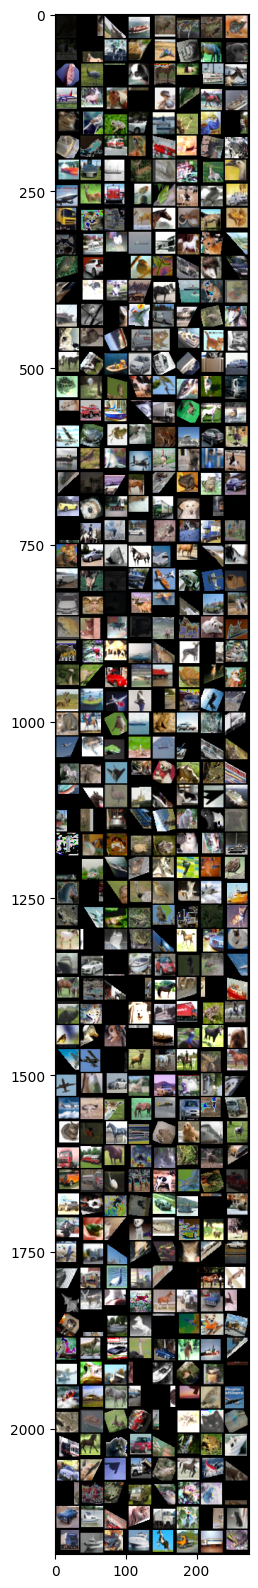

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.cpu().numpy()
    plt.figure(figsize=(25, 20))  # Adjust the width and height as needed
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
print(f'Dataset type "{DATASET_TYPE}" displaying...\n')

if DATASET_TYPE=='custom':
    dataiter = iter(custom_trainloader)
    images, labels, confidences = next(dataiter)
    # print labels 
    if isinstance(confidences, list):
        # in case we have confidence 
        confidences = confidences[1]
        
    print(' '.join(f'{classes[labels[j]]:5s}: {confidences[j].item():.2f}' for j in range(batch_size)))
elif DATASET_TYPE=='baseline':
#     if training baseline model
    dataiter = iter(baseline_trainloader)
    images, labels = next(dataiter)
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
else:
    raise ValueError(f'Dataset type {DATASET_TYPE} not supported')
    
# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np


# Manual implementation of ResNet18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling layer
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)  # Apply global average pooling
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



# ResNet18 Architecture
def ResNet18(num_classes=num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [7]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform(m.weight, gain=np.sqrt(2))
        init.constant(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant(m.weight, 1)
        init.constant(m.bias, 0)

class WideBasic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(WideBasic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate=0.3, num_classes=num_classes, factor=1, block=WideBasic):
        super(WideResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (int)((depth-4)/6)
        k = widen_factor

        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0], stride=1)
        self.layer1 = self._wide_layer(block, nStages[1], n, dropout_rate, stride=factor)
        self.layer2 = self._wide_layer(block, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(block, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

def WideResNet_28_4(num_classes, factor=1, block=WideBasic, dropout_rate=0.3):
    return WideResNet(depth=28, widen_factor=4, dropout_rate=dropout_rate, num_classes=num_classes, factor=factor, block=block)

## Model Training

In [8]:
# Initialize the model
net = WideResNet_28_4(num_classes=num_classes)
net.to(device)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): WideBasic(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): WideBasic(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, ke

In [9]:
def soft_loss2(pred, label, confidence):
    log_prob = F.log_softmax(pred, dim=1)
    n_class = pred.size(1)

    # Make soft one-hot target
    label = label.unsqueeze(1)
    confidence = confidence.unsqueeze(1)
    one_hot = torch.ones_like(pred) * (1 - confidence) / (n_class - 1)
    one_hot.scatter_(dim=1, index=label, src=confidence)
    # Compute weighted KL loss
    kl = confidence * F.kl_div(input=log_prob, target=one_hot, reduction="none").sum(-1)        # Weighted
#     kl = F.kl_div(input=log_prob, target=one_hot, reduction="none").sum(-1)                   # Unweighted
    
#     print(f'log_prob: {log_prob}\none_hot: {one_hot}\nkl: {F.kl_div(input=log_prob, target=one_hot, reduction="none").sum(-1)}')
    return kl.mean()



# def soft_loss2(pred, label, confidence):
#     label = label.unsqueeze(1)
#     target = label.long()
#     confidence = confidence.unsqueeze(1).float()
#     prob = (1 - (label - target))
#     weight = torch.ones_like(prob).float()
#     n_classes = pred.size(1)

#     # one_hot = (torch.ones_like(pred) * (1 - confidence) / (n_classes - 1)).float()
#     # one_hot.scatter_(dim=1, index=target, src=confidence)
#     one_hot = torch.zeros_like(pred).float()
#     one_hot.scatter_(dim=1, index=torch.ones_like(target)*(n_classes - 1), src=(1 - prob.float()))
#     one_hot.scatter_(dim=1, index=target, src=prob.float())
#     log_prob = F.log_softmax(pred, dim=1)
#     kl = confidence * F.kl_div(input=log_prob.float(), target=one_hot.float(), reduction='none').sum(-1)
#     return kl.mean()

In [10]:
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.15, momentum=0.9, weight_decay=1e-4)

# Initialize the scheduler
epochs = 100
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)  # Cosine Annealing LR Scheduler

# For plotting
train_losses, test_accuracies = [], []

# Training loop
print(f'\nStart Training...\n')
for epoch in range(epochs):  # loop over the dataset multiple times
    
    start_time = time.time()
    
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    total = 0
    correct = 0
#     confidences = None
    
    net.train()
    
#     for i, (inputs, labels) in enumerate(baseline_trainloader):
    for i, (inputs, labels, confidences) in enumerate(custom_trainloader):
        if DATASET_TYPE=='custom' and confidences is None:
            raise ValueError('Dataset type do not match data loader')
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # when the model returns [augmentation_magnitude, confidence_aa], which is the case
#         only when TA with soft labels is applied
        if confidences is not None and isinstance(confidences, list):
            confidences = confidences[1]
            
        # get the inputs
        if confidences is not None:
            inputs, labels, confidences = inputs.to(device), labels.to(device), confidences.to(device)
        else:
            inputs, labels = inputs.to(device), labels.to(device)
    
        # Convert labels to one-hot encoded vectors
#         labels_one_hot = F.one_hot(labels, num_classes=10).float()
        
        # forward + backward + optimize
        outputs = net(inputs)
#         print(f'pred: {outputs}\tlabel: {labels}\tconf: {confidences}')
        if DATASET_TYPE=='custom':
            loss = soft_loss2(pred=outputs, label=labels, confidence=confidences)
        else:
            loss = criterion(outputs, labels)
#         print(f'Loss: {loss:.3f}\tHard Loss: {hloss:.3f}')

        # Check for correct training
        if np.isnan(loss.detach().cpu().numpy()):
            raise ValueError('Loss calculation not correct')
    
        loss.backward()
        optimizer.step()
        if tpu:
            xm.mark_step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    with torch.no_grad():
        net.eval()
        for images, labels in baseline_testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # calculate and print average loss for current epoch
    average_loss = running_loss / len(custom_trainloader)
    train_losses.append(average_loss)
    
    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)
    
    print(f'\nEpoch {epoch + 1} - Loss: {average_loss:.3f} - Test Accuracy: {100 * test_accuracy: .3f}')    
    
    scheduler.step()
    end_time = time.time()
    print(f'\nProcessing time: {(end_time - start_time): 3f} seconds.')

print('Finished Training')

# Save the trained model
PATH = f'/kaggle/working/{DATASET_NAME}_net_ta_{DATASET_TYPE}_{epochs}_w.pth'
torch.save(net.state_dict(), PATH)


Start Training...



/usr/local/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: aten::kl_div: an autograd kernel was not registered to the Autograd key(s) but we are trying to backprop through it. This may lead to silently incorrect behavior. This behavior is deprecated and will be removed in a future version of PyTorch. If your operator is differentiable, please ensure you have registered an autograd kernel to the correct Autograd key (e.g. DispatchKey::Autograd, DispatchKey::CompositeImplicitAutograd). If your operator is not differentiable, or to squash this warning and use the previous behavior, please register torch::CppFunction::makeFallthrough() to DispatchKey::Autograd. (Triggered internally at ../torch/csrc/autograd/autograd_not_implemented_fallback.cpp:63.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



Epoch 1 - Loss: 1.315 - Test Accuracy:  34.880

Processing time:  91.575296 seconds.



Epoch 2 - Loss: 1.093 - Test Accuracy:  44.840

Processing time:  52.764958 seconds.



Epoch 3 - Loss: 0.926 - Test Accuracy:  46.880

Processing time:  33.849239 seconds.



Epoch 4 - Loss: 0.823 - Test Accuracy:  54.720

Processing time:  33.844065 seconds.



Epoch 5 - Loss: 0.756 - Test Accuracy:  60.310

Processing time:  33.077621 seconds.



Epoch 6 - Loss: 0.687 - Test Accuracy:  56.320

Processing time:  33.579147 seconds.



Epoch 7 - Loss: 0.637 - Test Accuracy:  57.450

Processing time:  33.243841 seconds.



Epoch 8 - Loss: 0.593 - Test Accuracy:  73.760

Processing time:  32.898371 seconds.



Epoch 9 - Loss: 0.567 - Test Accuracy:  64.430

Processing time:  33.447774 seconds.



Epoch 10 - Loss: 0.535 - Test Accuracy:  67.910

Processing time:  33.691680 seconds.



Epoch 11 - Loss: 0.512 - Test Accuracy:  59.730

Processing time:  33.714666 seconds.



Epoch 12 - Loss: 0.497 - Test Accuracy:  79.820

Processing time:  33.403323 seconds.



Epoch 13 - Loss: 0.477 - Test Accuracy:  78.780

Processing time:  33.451791 seconds.



Epoch 14 - Loss: 0.464 - Test Accuracy:  74.890

Processing time:  33.381909 seconds.



Epoch 15 - Loss: 0.444 - Test Accuracy:  79.110

Processing time:  33.054642 seconds.



Epoch 16 - Loss: 0.434 - Test Accuracy:  79.540

Processing time:  33.486180 seconds.



Epoch 17 - Loss: 0.417 - Test Accuracy:  81.470

Processing time:  33.068553 seconds.



Epoch 18 - Loss: 0.405 - Test Accuracy:  82.950

Processing time:  33.303382 seconds.



Epoch 19 - Loss: 0.402 - Test Accuracy:  84.310

Processing time:  33.301234 seconds.



Epoch 20 - Loss: 0.388 - Test Accuracy:  70.080

Processing time:  33.015012 seconds.



Epoch 21 - Loss: 0.383 - Test Accuracy:  84.730

Processing time:  34.519106 seconds.



Epoch 22 - Loss: 0.368 - Test Accuracy:  83.840

Processing time:  32.389059 seconds.



Epoch 23 - Loss: 0.365 - Test Accuracy:  79.500

Processing time:  32.267779 seconds.



Epoch 24 - Loss: 0.349 - Test Accuracy:  81.140

Processing time:  34.077802 seconds.



Epoch 25 - Loss: 0.342 - Test Accuracy:  86.450

Processing time:  33.690961 seconds.



Epoch 26 - Loss: 0.336 - Test Accuracy:  85.260

Processing time:  33.642279 seconds.



Epoch 27 - Loss: 0.338 - Test Accuracy:  86.820

Processing time:  33.790240 seconds.



Epoch 28 - Loss: 0.330 - Test Accuracy:  86.910

Processing time:  33.282695 seconds.



Epoch 29 - Loss: 0.323 - Test Accuracy:  85.040

Processing time:  33.455996 seconds.



Epoch 30 - Loss: 0.314 - Test Accuracy:  85.910

Processing time:  34.986487 seconds.



Epoch 31 - Loss: 0.312 - Test Accuracy:  84.540

Processing time:  33.315089 seconds.



Epoch 32 - Loss: 0.300 - Test Accuracy:  82.570

Processing time:  32.570299 seconds.



Epoch 33 - Loss: 0.297 - Test Accuracy:  83.460

Processing time:  34.272260 seconds.



Epoch 34 - Loss: 0.290 - Test Accuracy:  87.120

Processing time:  33.691349 seconds.



Epoch 35 - Loss: 0.289 - Test Accuracy:  88.860

Processing time:  33.115844 seconds.



Epoch 36 - Loss: 0.282 - Test Accuracy:  86.930

Processing time:  33.432081 seconds.



Epoch 37 - Loss: 0.276 - Test Accuracy:  84.770

Processing time:  33.461054 seconds.



Epoch 38 - Loss: 0.272 - Test Accuracy:  89.750

Processing time:  33.930013 seconds.



Epoch 39 - Loss: 0.267 - Test Accuracy:  88.190

Processing time:  33.777733 seconds.



Epoch 40 - Loss: 0.260 - Test Accuracy:  89.540

Processing time:  33.387648 seconds.



Epoch 41 - Loss: 0.263 - Test Accuracy:  89.830

Processing time:  33.525470 seconds.



Epoch 42 - Loss: 0.255 - Test Accuracy:  90.780

Processing time:  34.209562 seconds.



Epoch 43 - Loss: 0.251 - Test Accuracy:  88.200

Processing time:  33.345978 seconds.



Epoch 44 - Loss: 0.249 - Test Accuracy:  85.190

Processing time:  32.965720 seconds.



Epoch 45 - Loss: 0.242 - Test Accuracy:  90.440

Processing time:  33.337769 seconds.



Epoch 46 - Loss: 0.236 - Test Accuracy:  90.600

Processing time:  33.551427 seconds.



Epoch 47 - Loss: 0.236 - Test Accuracy:  90.510

Processing time:  32.538419 seconds.



Epoch 48 - Loss: 0.228 - Test Accuracy:  90.110

Processing time:  33.692701 seconds.



Epoch 49 - Loss: 0.228 - Test Accuracy:  90.150

Processing time:  33.924711 seconds.



Epoch 50 - Loss: 0.228 - Test Accuracy:  88.030

Processing time:  33.970306 seconds.



Epoch 51 - Loss: 0.218 - Test Accuracy:  90.940

Processing time:  34.366223 seconds.



Epoch 52 - Loss: 0.218 - Test Accuracy:  89.940

Processing time:  33.782454 seconds.



Epoch 53 - Loss: 0.211 - Test Accuracy:  89.880

Processing time:  34.581763 seconds.



Epoch 54 - Loss: 0.209 - Test Accuracy:  91.300

Processing time:  33.606571 seconds.



Epoch 55 - Loss: 0.206 - Test Accuracy:  90.910

Processing time:  33.390254 seconds.



Epoch 56 - Loss: 0.200 - Test Accuracy:  91.630

Processing time:  32.925309 seconds.



Epoch 57 - Loss: 0.199 - Test Accuracy:  91.310

Processing time:  34.046422 seconds.



Epoch 58 - Loss: 0.194 - Test Accuracy:  92.780

Processing time:  33.391662 seconds.



Epoch 59 - Loss: 0.191 - Test Accuracy:  92.450

Processing time:  33.790128 seconds.



Epoch 60 - Loss: 0.188 - Test Accuracy:  92.190

Processing time:  33.537170 seconds.



Epoch 61 - Loss: 0.182 - Test Accuracy:  92.610

Processing time:  33.574955 seconds.



Epoch 62 - Loss: 0.184 - Test Accuracy:  91.640

Processing time:  32.917109 seconds.



Epoch 63 - Loss: 0.178 - Test Accuracy:  92.410

Processing time:  33.415095 seconds.



Epoch 64 - Loss: 0.174 - Test Accuracy:  92.800

Processing time:  33.996448 seconds.



Epoch 65 - Loss: 0.172 - Test Accuracy:  93.140

Processing time:  33.780764 seconds.



Epoch 66 - Loss: 0.168 - Test Accuracy:  92.110

Processing time:  33.666150 seconds.



Epoch 67 - Loss: 0.166 - Test Accuracy:  92.560

Processing time:  33.741343 seconds.



Epoch 68 - Loss: 0.168 - Test Accuracy:  93.050

Processing time:  33.172667 seconds.



Epoch 69 - Loss: 0.159 - Test Accuracy:  93.080

Processing time:  32.561638 seconds.



Epoch 70 - Loss: 0.160 - Test Accuracy:  93.440

Processing time:  32.601240 seconds.



Epoch 71 - Loss: 0.158 - Test Accuracy:  93.040

Processing time:  33.116593 seconds.



Epoch 72 - Loss: 0.154 - Test Accuracy:  93.390

Processing time:  33.839064 seconds.



Epoch 73 - Loss: 0.155 - Test Accuracy:  93.440

Processing time:  33.808281 seconds.



Epoch 74 - Loss: 0.148 - Test Accuracy:  93.350

Processing time:  33.821838 seconds.



Epoch 75 - Loss: 0.146 - Test Accuracy:  93.250

Processing time:  33.437208 seconds.



Epoch 76 - Loss: 0.144 - Test Accuracy:  93.990

Processing time:  33.707703 seconds.



Epoch 77 - Loss: 0.144 - Test Accuracy:  93.570

Processing time:  33.318491 seconds.



Epoch 78 - Loss: 0.144 - Test Accuracy:  93.480

Processing time:  33.053482 seconds.



Epoch 79 - Loss: 0.138 - Test Accuracy:  94.230

Processing time:  33.658090 seconds.



Epoch 80 - Loss: 0.137 - Test Accuracy:  94.110

Processing time:  33.462055 seconds.



Epoch 81 - Loss: 0.133 - Test Accuracy:  93.890

Processing time:  33.563432 seconds.



Epoch 82 - Loss: 0.133 - Test Accuracy:  94.580

Processing time:  33.799728 seconds.



Epoch 83 - Loss: 0.127 - Test Accuracy:  94.460

Processing time:  33.572531 seconds.



Epoch 84 - Loss: 0.131 - Test Accuracy:  94.250

Processing time:  33.804496 seconds.



Epoch 85 - Loss: 0.129 - Test Accuracy:  94.110

Processing time:  33.810997 seconds.



Epoch 86 - Loss: 0.128 - Test Accuracy:  94.570

Processing time:  33.511547 seconds.



Epoch 87 - Loss: 0.129 - Test Accuracy:  94.460

Processing time:  33.766154 seconds.



Epoch 88 - Loss: 0.128 - Test Accuracy:  94.660

Processing time:  33.315992 seconds.



Epoch 89 - Loss: 0.122 - Test Accuracy:  94.590

Processing time:  32.854194 seconds.



Epoch 90 - Loss: 0.123 - Test Accuracy:  94.590

Processing time:  33.885294 seconds.



Epoch 91 - Loss: 0.124 - Test Accuracy:  94.450

Processing time:  34.052034 seconds.



Epoch 92 - Loss: 0.121 - Test Accuracy:  94.620

Processing time:  33.534298 seconds.



Epoch 93 - Loss: 0.124 - Test Accuracy:  94.740

Processing time:  34.389853 seconds.



Epoch 94 - Loss: 0.123 - Test Accuracy:  94.740

Processing time:  33.636051 seconds.



Epoch 95 - Loss: 0.122 - Test Accuracy:  94.870

Processing time:  33.727314 seconds.



Epoch 96 - Loss: 0.120 - Test Accuracy:  94.720

Processing time:  34.478457 seconds.



Epoch 97 - Loss: 0.120 - Test Accuracy:  94.810

Processing time:  33.585085 seconds.



Epoch 98 - Loss: 0.120 - Test Accuracy:  94.770

Processing time:  33.689130 seconds.



Epoch 99 - Loss: 0.122 - Test Accuracy:  94.730

Processing time:  33.579504 seconds.



Epoch 100 - Loss: 0.122 - Test Accuracy:  94.880

Processing time:  33.715669 seconds.
Finished Training


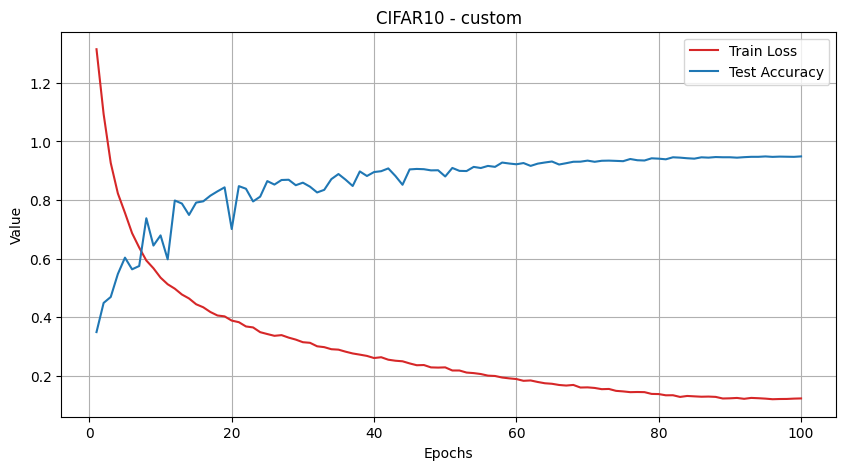

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='tab:red')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy', color='tab:blue')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title(f'{DATASET_NAME} - {DATASET_TYPE}')
plt.legend()
plt.grid(True)
plt.show()

Evaluate the model on Testset

In [12]:
import torch
import numpy as np

# Evaluate the CIFAR-10 dataset
correct = 0
total = 0

with torch.no_grad():
    net.eval()
    for images, labels in baseline_testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    if total == 0:
        print('No images found for CIFAR-10 dataset.')
    else:
        cifar10_accuracy = 100 * correct / total
        print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')

if not tpu:
    # Clear GPU memory
    torch.cuda.empty_cache()

    # Clear CPU memory
    torch.cuda.ipc_collect()

# Define the list of corruptions
corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
               'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
               'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
               'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# Define the batch size
batch_size = 256 

# Create an empty dictionary to store corrupted datasets
corrupted_datasets = {}

# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# List to store average accuracies for each corruption dataset
average_accuracies = []

# Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
for corruption in corruptions:
    print(f"Testing on corruption: {corruption}")

    # Load and test datasets for all 5 severity levels of the current corruption
    try:
        if DATASET_NAME=='CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
        elif DATASET_NAME=='CIFAR100':
            np_data_c = np.load(f'/kaggle/input/cifar-100-c/{corruption}.npy')
        else:
            raise ValueError(f'Corruption dataset {DATASET_NAME} not loaded')
            
        np_data_c_splits = np.array_split(np_data_c, 5)
        
        # List to store accuracies of all severity levels for averaging
        accuracies = []

        for i, np_data_c_split in enumerate(np_data_c_splits):
            custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

            # Testing loop for the current corruption dataset split
            correct = 0
            total = 0

            with torch.no_grad():
                images_loaded = 0  # Counter for images loaded for the current corruption
                for images, labels in custom_dataloader:
                    images_loaded += len(images)  # Increment the counter by the number of images loaded
                    images, labels = images.to(device), labels.to(device)
                    # Calculate outputs by running images through the network
                    outputs = net(images)
                    # The class with the highest energy is chosen as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                if total == 0:
                    print(f'No images found for {corruption} dataset split {i+1}.')
                else:
                    accuracy = 100 * correct / total
                    print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
                    accuracies.append(accuracy)

                # Print the number of images loaded for the current corruption dataset split
                #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
                if not tpu:
                    # Clear GPU memory
                    torch.cuda.empty_cache()
                    # Clear CPU memory
                    torch.cuda.ipc_collect()

                # Delete variables to free up memory
                del custom_dataset
                del custom_dataloader

        # Calculate and print the average accuracy for the corruption dataset
        if accuracies:
            average_accuracy = sum(accuracies) / len(accuracies)
            average_accuracies.append(average_accuracy)
            print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

    except FileNotFoundError:
        print(f'Corruption {corruption} dataset not found.')
        continue

# Calculate and print the average robust accuracy
if average_accuracies:
    average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
    print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
else:
    print("No corrupt datasets found for evaluation.")

Accuracy of the network on the CIFAR-10 test dataset: 94.88 %
Testing on corruption: gaussian_noise


Accuracy of the network on gaussian_noise dataset split 1: 84.06 %


Accuracy of the network on gaussian_noise dataset split 2: 69.60 %


Accuracy of the network on gaussian_noise dataset split 3: 53.90 %


Accuracy of the network on gaussian_noise dataset split 4: 46.62 %


Accuracy of the network on gaussian_noise dataset split 5: 40.07 %
Average accuracy for gaussian_noise dataset: 58.85 %
Testing on corruption: shot_noise


Accuracy of the network on shot_noise dataset split 1: 88.61 %


Accuracy of the network on shot_noise dataset split 2: 82.43 %


Accuracy of the network on shot_noise dataset split 3: 66.32 %


Accuracy of the network on shot_noise dataset split 4: 59.01 %


Accuracy of the network on shot_noise dataset split 5: 47.81 %
Average accuracy for shot_noise dataset: 68.84 %
Testing on corruption: impulse_noise


Accuracy of the network on impulse_noise dataset split 1: 91.06 %


Accuracy of the network on impulse_noise dataset split 2: 85.80 %


Accuracy of the network on impulse_noise dataset split 3: 77.30 %


Accuracy of the network on impulse_noise dataset split 4: 52.30 %


Accuracy of the network on impulse_noise dataset split 5: 30.86 %
Average accuracy for impulse_noise dataset: 67.46 %
Testing on corruption: defocus_blur


Accuracy of the network on defocus_blur dataset split 1: 94.85 %


Accuracy of the network on defocus_blur dataset split 2: 94.31 %


Accuracy of the network on defocus_blur dataset split 3: 93.07 %


Accuracy of the network on defocus_blur dataset split 4: 90.12 %


Accuracy of the network on defocus_blur dataset split 5: 82.12 %
Average accuracy for defocus_blur dataset: 90.89 %
Testing on corruption: glass_blur


Accuracy of the network on glass_blur dataset split 1: 74.79 %


Accuracy of the network on glass_blur dataset split 2: 75.57 %


Accuracy of the network on glass_blur dataset split 3: 77.23 %


Accuracy of the network on glass_blur dataset split 4: 61.28 %


Accuracy of the network on glass_blur dataset split 5: 63.67 %
Average accuracy for glass_blur dataset: 70.51 %
Testing on corruption: motion_blur


Accuracy of the network on motion_blur dataset split 1: 92.32 %


Accuracy of the network on motion_blur dataset split 2: 88.31 %


Accuracy of the network on motion_blur dataset split 3: 82.65 %


Accuracy of the network on motion_blur dataset split 4: 82.67 %


Accuracy of the network on motion_blur dataset split 5: 76.13 %
Average accuracy for motion_blur dataset: 84.42 %
Testing on corruption: zoom_blur


Accuracy of the network on zoom_blur dataset split 1: 91.78 %


Accuracy of the network on zoom_blur dataset split 2: 91.44 %


Accuracy of the network on zoom_blur dataset split 3: 89.50 %


Accuracy of the network on zoom_blur dataset split 4: 87.45 %


Accuracy of the network on zoom_blur dataset split 5: 83.06 %
Average accuracy for zoom_blur dataset: 88.65 %
Testing on corruption: snow


Accuracy of the network on snow dataset split 1: 91.57 %


Accuracy of the network on snow dataset split 2: 85.45 %


Accuracy of the network on snow dataset split 3: 85.88 %


Accuracy of the network on snow dataset split 4: 83.35 %


Accuracy of the network on snow dataset split 5: 80.49 %
Average accuracy for snow dataset: 85.35 %
Testing on corruption: frost


Accuracy of the network on frost dataset split 1: 91.31 %


Accuracy of the network on frost dataset split 2: 87.49 %


Accuracy of the network on frost dataset split 3: 79.71 %


Accuracy of the network on frost dataset split 4: 77.71 %


Accuracy of the network on frost dataset split 5: 68.25 %
Average accuracy for frost dataset: 80.89 %
Testing on corruption: fog


Accuracy of the network on fog dataset split 1: 94.46 %


Accuracy of the network on fog dataset split 2: 93.63 %


Accuracy of the network on fog dataset split 3: 92.40 %


Accuracy of the network on fog dataset split 4: 90.11 %


Accuracy of the network on fog dataset split 5: 78.72 %
Average accuracy for fog dataset: 89.86 %
Testing on corruption: brightness


Accuracy of the network on brightness dataset split 1: 94.73 %


Accuracy of the network on brightness dataset split 2: 94.52 %


Accuracy of the network on brightness dataset split 3: 94.18 %


Accuracy of the network on brightness dataset split 4: 93.71 %


Accuracy of the network on brightness dataset split 5: 92.29 %
Average accuracy for brightness dataset: 93.89 %
Testing on corruption: contrast


Accuracy of the network on contrast dataset split 1: 94.18 %


Accuracy of the network on contrast dataset split 2: 92.52 %


Accuracy of the network on contrast dataset split 3: 91.13 %


Accuracy of the network on contrast dataset split 4: 88.76 %


Accuracy of the network on contrast dataset split 5: 78.12 %
Average accuracy for contrast dataset: 88.94 %
Testing on corruption: elastic_transform


Accuracy of the network on elastic_transform dataset split 1: 91.50 %


Accuracy of the network on elastic_transform dataset split 2: 91.85 %


Accuracy of the network on elastic_transform dataset split 3: 90.42 %


Accuracy of the network on elastic_transform dataset split 4: 84.05 %


Accuracy of the network on elastic_transform dataset split 5: 76.84 %
Average accuracy for elastic_transform dataset: 86.93 %
Testing on corruption: pixelate


Accuracy of the network on pixelate dataset split 1: 92.91 %


Accuracy of the network on pixelate dataset split 2: 88.67 %


Accuracy of the network on pixelate dataset split 3: 83.82 %


Accuracy of the network on pixelate dataset split 4: 65.48 %


Accuracy of the network on pixelate dataset split 5: 44.64 %
Average accuracy for pixelate dataset: 75.10 %
Testing on corruption: jpeg_compression


Accuracy of the network on jpeg_compression dataset split 1: 88.45 %


Accuracy of the network on jpeg_compression dataset split 2: 84.37 %


Accuracy of the network on jpeg_compression dataset split 3: 82.56 %


Accuracy of the network on jpeg_compression dataset split 4: 80.31 %


Accuracy of the network on jpeg_compression dataset split 5: 77.18 %
Average accuracy for jpeg_compression dataset: 82.57 %
Testing on corruption: speckle_noise


Accuracy of the network on speckle_noise dataset split 1: 88.45 %


Accuracy of the network on speckle_noise dataset split 2: 79.14 %


Accuracy of the network on speckle_noise dataset split 3: 73.72 %


Accuracy of the network on speckle_noise dataset split 4: 62.84 %


Accuracy of the network on speckle_noise dataset split 5: 52.41 %
Average accuracy for speckle_noise dataset: 71.31 %
Testing on corruption: gaussian_blur


Accuracy of the network on gaussian_blur dataset split 1: 94.84 %


Accuracy of the network on gaussian_blur dataset split 2: 93.03 %


Accuracy of the network on gaussian_blur dataset split 3: 90.70 %


Accuracy of the network on gaussian_blur dataset split 4: 87.39 %


Accuracy of the network on gaussian_blur dataset split 5: 76.61 %
Average accuracy for gaussian_blur dataset: 88.51 %
Testing on corruption: spatter


Accuracy of the network on spatter dataset split 1: 93.14 %


Accuracy of the network on spatter dataset split 2: 89.89 %


Accuracy of the network on spatter dataset split 3: 86.27 %


Accuracy of the network on spatter dataset split 4: 91.13 %


Accuracy of the network on spatter dataset split 5: 86.44 %
Average accuracy for spatter dataset: 89.37 %
Testing on corruption: saturate


Accuracy of the network on saturate dataset split 1: 92.89 %


Accuracy of the network on saturate dataset split 2: 90.93 %


Accuracy of the network on saturate dataset split 3: 94.53 %


Accuracy of the network on saturate dataset split 4: 93.33 %


Accuracy of the network on saturate dataset split 5: 91.13 %
Average accuracy for saturate dataset: 92.56 %
Average Robust Accuracy: 81.84 %


In [13]:
# Load the model checkpoint
net = WideResNet_28_4(num_classes=100)
checkpoint_path = '/kaggle/working/MasterArbeit/models/cifar100_net_ta_pytorch_200.pth'
checkpoint = torch.load(checkpoint_path)
net.load_state_dict(checkpoint, strict=False)
net.to(device)

import torch
import numpy as np


# Evaluate the CIFAR-10 dataset
correct = 0
total = 0

with torch.no_grad():
    net.eval()
    for images, labels in baseline_testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    if total == 0:
        print('No images found for CIFAR-10 dataset.')
    else:
        cifar10_accuracy = 100 * correct / total
        print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')
        
if not tpu:
    # Clear GPU memory
    torch.cuda.empty_cache()

    # Clear CPU memory
    torch.cuda.ipc_collect()

# Define the list of corruptions
corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
               'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
               'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
               'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# Define the batch size
batch_size = 256 

# Create an empty dictionary to store corrupted datasets
corrupted_datasets = {}

# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# List to store average accuracies for each corruption dataset
average_accuracies = []

# Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
for corruption in corruptions:
    print(f"Testing on corruption: {corruption}")

    # Load and test datasets for all 5 severity levels of the current corruption
    try:
        if DATASET_NAME=='CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
        elif DATASET_NAME=='CIFAR100':
            np_data_c = np.load(f'/kaggle/input/cifar-100-c/{corruption}.npy')
        else:
            raise ValueError(f'Corruption dataset {DATASET_NAME} not loaded')
        np_data_c_splits = np.array_split(np_data_c, 5)
        
        # List to store accuracies of all severity levels for averaging
        accuracies = []

        for i, np_data_c_split in enumerate(np_data_c_splits):
            custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

            # Testing loop for the current corruption dataset split
            correct = 0
            total = 0

            with torch.no_grad():
                images_loaded = 0  # Counter for images loaded for the current corruption
                for images, labels in custom_dataloader:
                    images_loaded += len(images)  # Increment the counter by the number of images loaded
                    images, labels = images.to(device), labels.to(device)
                    # Calculate outputs by running images through the network
                    outputs = net(images)
                    # The class with the highest energy is chosen as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                if total == 0:
                    print(f'No images found for {corruption} dataset split {i+1}.')
                else:
                    accuracy = 100 * correct / total
                    print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
                    accuracies.append(accuracy)

                # Print the number of images loaded for the current corruption dataset split
                #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
                if not tpu:
                    # Clear GPU memory
                    torch.cuda.empty_cache()
                    # Clear CPU memory
                    torch.cuda.ipc_collect()

                # Delete variables to free up memory
                del custom_dataset
                del custom_dataloader

        # Calculate and print the average accuracy for the corruption dataset
        if accuracies:
            average_accuracy = sum(accuracies) / len(accuracies)
            average_accuracies.append(average_accuracy)
            print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

    except FileNotFoundError:
        print(f'Corruption {corruption} dataset not found.')
        continue

# Calculate and print the average robust accuracy
if average_accuracies:
    average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
    print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
else:
    print("No corrupt datasets found for evaluation.")

/tmp/ipykernel_77/1963142385.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Accuracy of the network on the CIFAR-10 test dataset: 0.48 %
Testing on corruption: gaussian_noise


Accuracy of the network on gaussian_noise dataset split 1: 0.52 %


Accuracy of the network on gaussian_noise dataset split 2: 0.40 %


Accuracy of the network on gaussian_noise dataset split 3: 0.32 %


Accuracy of the network on gaussian_noise dataset split 4: 0.21 %


Accuracy of the network on gaussian_noise dataset split 5: 0.23 %
Average accuracy for gaussian_noise dataset: 0.34 %
Testing on corruption: shot_noise


Accuracy of the network on shot_noise dataset split 1: 0.63 %


Accuracy of the network on shot_noise dataset split 2: 0.79 %


Accuracy of the network on shot_noise dataset split 3: 0.41 %


Accuracy of the network on shot_noise dataset split 4: 0.42 %


Accuracy of the network on shot_noise dataset split 5: 0.29 %
Average accuracy for shot_noise dataset: 0.51 %
Testing on corruption: impulse_noise


Accuracy of the network on impulse_noise dataset split 1: 0.49 %


Accuracy of the network on impulse_noise dataset split 2: 0.67 %


Accuracy of the network on impulse_noise dataset split 3: 0.61 %


Accuracy of the network on impulse_noise dataset split 4: 0.45 %


Accuracy of the network on impulse_noise dataset split 5: 0.25 %
Average accuracy for impulse_noise dataset: 0.49 %
Testing on corruption: defocus_blur


Accuracy of the network on defocus_blur dataset split 1: 0.48 %


Accuracy of the network on defocus_blur dataset split 2: 0.45 %


Accuracy of the network on defocus_blur dataset split 3: 0.52 %


Accuracy of the network on defocus_blur dataset split 4: 0.47 %


Accuracy of the network on defocus_blur dataset split 5: 0.48 %
Average accuracy for defocus_blur dataset: 0.48 %
Testing on corruption: glass_blur


Accuracy of the network on glass_blur dataset split 1: 0.61 %


Accuracy of the network on glass_blur dataset split 2: 0.63 %


Accuracy of the network on glass_blur dataset split 3: 0.74 %


Accuracy of the network on glass_blur dataset split 4: 0.58 %


Accuracy of the network on glass_blur dataset split 5: 0.76 %
Average accuracy for glass_blur dataset: 0.66 %
Testing on corruption: motion_blur


Accuracy of the network on motion_blur dataset split 1: 0.55 %


Accuracy of the network on motion_blur dataset split 2: 0.60 %


Accuracy of the network on motion_blur dataset split 3: 0.78 %


Accuracy of the network on motion_blur dataset split 4: 0.86 %


Accuracy of the network on motion_blur dataset split 5: 0.81 %
Average accuracy for motion_blur dataset: 0.72 %
Testing on corruption: zoom_blur


Accuracy of the network on zoom_blur dataset split 1: 0.69 %


Accuracy of the network on zoom_blur dataset split 2: 0.79 %


Accuracy of the network on zoom_blur dataset split 3: 0.93 %


Accuracy of the network on zoom_blur dataset split 4: 0.98 %


Accuracy of the network on zoom_blur dataset split 5: 0.96 %
Average accuracy for zoom_blur dataset: 0.87 %
Testing on corruption: snow


Accuracy of the network on snow dataset split 1: 0.45 %


Accuracy of the network on snow dataset split 2: 0.38 %


Accuracy of the network on snow dataset split 3: 0.66 %


Accuracy of the network on snow dataset split 4: 0.58 %


Accuracy of the network on snow dataset split 5: 0.42 %
Average accuracy for snow dataset: 0.50 %
Testing on corruption: frost


Accuracy of the network on frost dataset split 1: 0.44 %


Accuracy of the network on frost dataset split 2: 0.31 %


Accuracy of the network on frost dataset split 3: 0.16 %


Accuracy of the network on frost dataset split 4: 0.15 %


Accuracy of the network on frost dataset split 5: 0.16 %
Average accuracy for frost dataset: 0.24 %
Testing on corruption: fog


Accuracy of the network on fog dataset split 1: 0.42 %


Accuracy of the network on fog dataset split 2: 0.40 %


Accuracy of the network on fog dataset split 3: 0.37 %


Accuracy of the network on fog dataset split 4: 0.54 %


Accuracy of the network on fog dataset split 5: 0.63 %
Average accuracy for fog dataset: 0.47 %
Testing on corruption: brightness


Accuracy of the network on brightness dataset split 1: 0.42 %


Accuracy of the network on brightness dataset split 2: 0.43 %


Accuracy of the network on brightness dataset split 3: 0.41 %


Accuracy of the network on brightness dataset split 4: 0.46 %


Accuracy of the network on brightness dataset split 5: 0.49 %
Average accuracy for brightness dataset: 0.44 %
Testing on corruption: contrast


Accuracy of the network on contrast dataset split 1: 0.41 %


Accuracy of the network on contrast dataset split 2: 0.33 %


Accuracy of the network on contrast dataset split 3: 0.31 %


Accuracy of the network on contrast dataset split 4: 0.23 %


Accuracy of the network on contrast dataset split 5: 0.19 %
Average accuracy for contrast dataset: 0.29 %
Testing on corruption: elastic_transform


Accuracy of the network on elastic_transform dataset split 1: 0.46 %


Accuracy of the network on elastic_transform dataset split 2: 0.60 %


Accuracy of the network on elastic_transform dataset split 3: 0.55 %


Accuracy of the network on elastic_transform dataset split 4: 0.63 %


Accuracy of the network on elastic_transform dataset split 5: 0.92 %
Average accuracy for elastic_transform dataset: 0.63 %
Testing on corruption: pixelate


Accuracy of the network on pixelate dataset split 1: 0.52 %


Accuracy of the network on pixelate dataset split 2: 0.32 %


Accuracy of the network on pixelate dataset split 3: 0.34 %


Accuracy of the network on pixelate dataset split 4: 0.24 %


Accuracy of the network on pixelate dataset split 5: 0.46 %
Average accuracy for pixelate dataset: 0.38 %
Testing on corruption: jpeg_compression


Accuracy of the network on jpeg_compression dataset split 1: 0.57 %


Accuracy of the network on jpeg_compression dataset split 2: 0.88 %


Accuracy of the network on jpeg_compression dataset split 3: 0.84 %


Accuracy of the network on jpeg_compression dataset split 4: 1.10 %


Accuracy of the network on jpeg_compression dataset split 5: 1.12 %
Average accuracy for jpeg_compression dataset: 0.90 %
Testing on corruption: speckle_noise


Accuracy of the network on speckle_noise dataset split 1: 0.72 %


Accuracy of the network on speckle_noise dataset split 2: 0.69 %


Accuracy of the network on speckle_noise dataset split 3: 0.61 %


Accuracy of the network on speckle_noise dataset split 4: 0.51 %


Accuracy of the network on speckle_noise dataset split 5: 0.39 %
Average accuracy for speckle_noise dataset: 0.58 %
Testing on corruption: gaussian_blur


Accuracy of the network on gaussian_blur dataset split 1: 0.48 %


Accuracy of the network on gaussian_blur dataset split 2: 0.51 %


Accuracy of the network on gaussian_blur dataset split 3: 0.53 %


Accuracy of the network on gaussian_blur dataset split 4: 0.49 %


Accuracy of the network on gaussian_blur dataset split 5: 0.58 %
Average accuracy for gaussian_blur dataset: 0.52 %
Testing on corruption: spatter


Accuracy of the network on spatter dataset split 1: 0.37 %


Accuracy of the network on spatter dataset split 2: 0.53 %


Accuracy of the network on spatter dataset split 3: 0.62 %


Accuracy of the network on spatter dataset split 4: 0.58 %


Accuracy of the network on spatter dataset split 5: 0.56 %
Average accuracy for spatter dataset: 0.53 %
Testing on corruption: saturate


Accuracy of the network on saturate dataset split 1: 0.51 %


Accuracy of the network on saturate dataset split 2: 0.85 %


Accuracy of the network on saturate dataset split 3: 0.61 %


Accuracy of the network on saturate dataset split 4: 0.92 %


Accuracy of the network on saturate dataset split 5: 0.98 %
Average accuracy for saturate dataset: 0.77 %
Average Robust Accuracy: 0.54 %
